# Case Study: Predicting Auto Insurance Claims

## Objective

The goal is to predict the likelihood of a driver making an insurance claim within the next year. By building a predictive model, insurance companies can better assess risk, set fair premiums, and reduce financial losses.

## Dataset Overview

The dataset contains over 590,000 policyholder records with binary, categorical, and continuous features. All feature names are anonymized (e.g., ps_ind_01, ps_car_07_cat) and no personally identifiable information is included. The target variable is binary, indicating whether a claim was filed (1) or not (0). The data is highly imbalanced, with only a small fraction of drivers filing claims.

Unlike typical datasets, this one does not use NaN to represent missing values. Instead, missing information is encoded as -1 across several features (e.g., ps_car_03_cat, ps_car_05_cat). This means handling -1 values is an important preprocessing step.

**Source:** [Porto Seguro Safe Driver Prediction – Kaggle](https://www.kaggle.com/competitions/porto-seguro-safe-driver-prediction/overview)

## Load the Dataset

In [1]:
import pandas as pd

# Load the dataset
df_train = pd.read_csv('./data/train.csv')
print(df_train['target'].value_counts())


target
0    573518
1     21694
Name: count, dtype: int64


We can already see that there are imbalanced data in the target column.

In [2]:
df_train.shape

(595212, 59)

In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 595212 entries, 0 to 595211
Data columns (total 59 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id              595212 non-null  int64  
 1   target          595212 non-null  int64  
 2   ps_ind_01       595212 non-null  int64  
 3   ps_ind_02_cat   595212 non-null  int64  
 4   ps_ind_03       595212 non-null  int64  
 5   ps_ind_04_cat   595212 non-null  int64  
 6   ps_ind_05_cat   595212 non-null  int64  
 7   ps_ind_06_bin   595212 non-null  int64  
 8   ps_ind_07_bin   595212 non-null  int64  
 9   ps_ind_08_bin   595212 non-null  int64  
 10  ps_ind_09_bin   595212 non-null  int64  
 11  ps_ind_10_bin   595212 non-null  int64  
 12  ps_ind_11_bin   595212 non-null  int64  
 13  ps_ind_12_bin   595212 non-null  int64  
 14  ps_ind_13_bin   595212 non-null  int64  
 15  ps_ind_14       595212 non-null  int64  
 16  ps_ind_15       595212 non-null  int64  
 17  ps_ind_16_

In [4]:
all_cols = df_train.columns.tolist()
feature_cols = [c for c in all_cols if c not in ['id', 'target']]

bin_features = [c for c in feature_cols if c.endswith('_bin')]
cat_features = [c for c in feature_cols if c.endswith('_cat')]
num_features = [c for c in feature_cols if c not in bin_features + cat_features]


print(f"Binary cols: {len(bin_features)} | Categorical cols: {len(cat_features)} | Numeric/Ordinal cols: {len(num_features)}")

Binary cols: 17 | Categorical cols: 14 | Numeric/Ordinal cols: 26


## Exploratory Data Analysis (EDA)

### Step 1: Analyze target variable distribution ( Insurance Claimed vs Insurance not granted )

In [5]:
df_train['target'].value_counts(normalize=True)

target
0    0.963552
1    0.036448
Name: proportion, dtype: float64

96.35% of rows have target = 0 and 3.64% of rows have target = 1

Class 0: 573518
Class 1: 21694
Proportion: 26.44 : 1


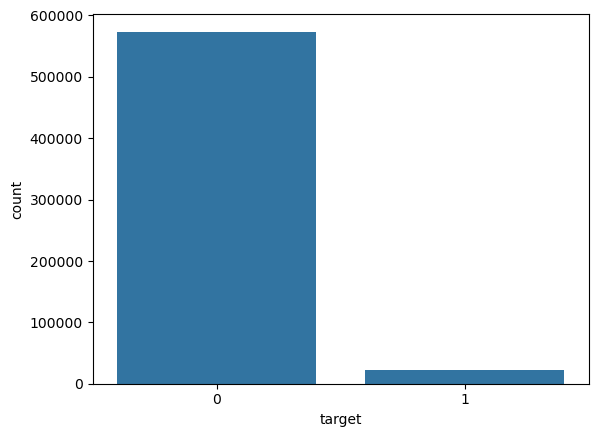

In [6]:
# Analyze target variable distribution

import matplotlib.pyplot as plt
import seaborn as sns

target_count = df_train.target.value_counts()
print('Class 0:', target_count[0])
print('Class 1:', target_count[1])
print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')

sns.countplot(x='target',data = df_train)
plt.show()

Here we can clearly see that there is imbalance in data i.e claims of insurance are unusual (not granted/unclaimed).

### Step 2: Check for missing values

In [7]:
# Check for missing values in each column
missing = (df_train == -1).sum()
missing = missing[missing > 0].sort_values(ascending=False)

# Convert to percentage
missing_percent = (missing / len(df_train)) * 100

missing_df = pd.DataFrame({
    'Missing Count': missing,
    'Missing %': missing_percent.round(2)
})
print(missing_df)


               Missing Count  Missing %
ps_car_03_cat         411231      69.09
ps_car_05_cat         266551      44.78
ps_reg_03             107772      18.11
ps_car_14              42620       7.16
ps_car_07_cat          11489       1.93
ps_ind_05_cat           5809       0.98
ps_car_09_cat            569       0.10
ps_ind_02_cat            216       0.04
ps_car_01_cat            107       0.02
ps_ind_04_cat             83       0.01
ps_car_02_cat              5       0.00
ps_car_11                  5       0.00
ps_car_12                  1       0.00


There are few columns with lots of missing values, so these can be removed.
- Two categorical features (ps_car_03_cat and ps_car_05_cat) have very high missing rates (69% and 45%), making them strong candidates for removal.
- Features such as ps_reg_03 (18% missing) and ps_car_14 (7% missing) will likely require imputation, while the remaining features have negligible missingness and can be safely imputed or kept.

Since the target is highly imbalanced, some of these features might still carry rare but potentially useful signals. Therefore, we should also check their association with the target via bivariate analysis before making final removal decisions.

### Step 3: Univariate Analysis

#### Count of 0s and 1s for each binary feature

In [8]:
# Count of 0s and 1s for each binary feature
bin_counts = df_train[bin_features].apply(pd.Series.value_counts).T.fillna(0).astype(int)
bin_counts.columns = ['Count_0', 'Count_1']
bin_counts['Proportion_of_1s'] = bin_counts['Count_1'] / (bin_counts['Count_0'] + bin_counts['Count_1'])

bin_counts.head(17)

,Count_0,Count_1,Proportion_of_1s
ps_ind_06_bin,360852,234360,0.393742
ps_ind_07_bin,442223,152989,0.257033
ps_ind_08_bin,497644,97568,0.163921
ps_ind_09_bin,484917,110295,0.185304
ps_ind_10_bin,594990,222,0.000373
ps_ind_11_bin,594205,1007,0.001692
ps_ind_12_bin,589594,5618,0.009439
ps_ind_13_bin,594648,564,0.000948
ps_ind_16_bin,201882,393330,0.660823
ps_ind_17_bin,523143,72069,0.121081


Some features are heavily skewed with almost all 0s (ps_ind_10_bin, ps_ind_11_bin, ps_ind_13_bin), indicating low variance and possibly low predictive value.

This low variance suggests they may contribute limited predictive power in distinguishing between classes. However, since the target variable itself is imbalanced, these rare 1s could still carry signal for the minority class, so their usefulness should be validated further (e.g., through correlation with the target or feature importance analysis) before removal.

Decision Rule:
- If a feature is rare + unrelated to target - drop (noise).

- If a feature is rare but highly predictive - keep

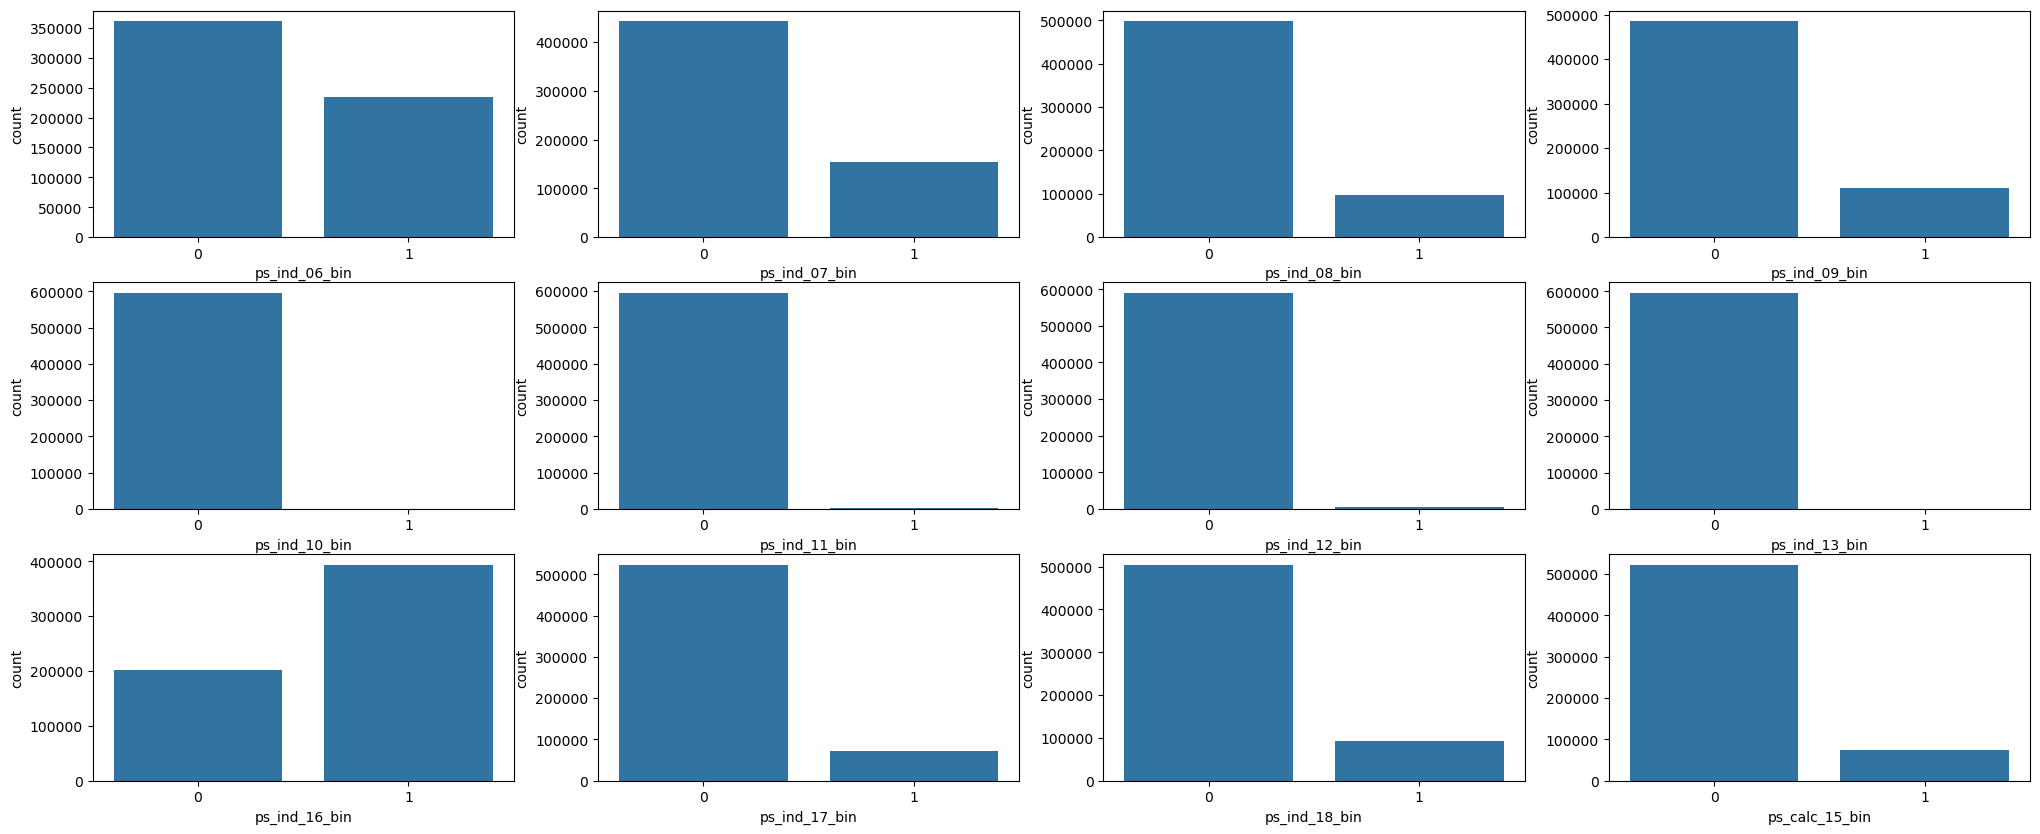

In [9]:
# Visualize binary feature distributions
fig, ax = plt.subplots(3, 4)
fig.set_size_inches((25,10))
cnt = 0
for i in range(3) :
  for j in range(4) :
    sns.countplot(x=bin_features[cnt], data = df_train, ax=ax[i,j])
    cnt+=1
plt.show()

#### Frequency counts of each categorical features

In [10]:
# Analyze categorical features
for col in cat_features:
    print(f"\n--- {col} ---")
    
    # Counts of each category
    counts = df_train[col].value_counts().sort_index()
    
    # Proportions of each category
    proportions = df_train[col].value_counts(normalize=True).sort_index().round(3)
    
    # Combine counts and proportions into a single table
    summary = pd.DataFrame({'Count': counts, 'Proportion': proportions})
    print(summary)



--- ps_ind_02_cat ---
                Count  Proportion
ps_ind_02_cat                    
-1                216       0.000
 1             431859       0.726
 2             123573       0.208
 3              28186       0.047
 4              11378       0.019

--- ps_ind_04_cat ---
                Count  Proportion
ps_ind_04_cat                    
-1                 83       0.000
 0             346965       0.583
 1             248164       0.417

--- ps_ind_05_cat ---
                Count  Proportion
ps_ind_05_cat                    
-1               5809       0.010
 0             528009       0.887
 1               8322       0.014
 2               4184       0.007
 3               8233       0.014
 4              18344       0.031
 5               1649       0.003
 6              20662       0.035

--- ps_car_01_cat ---
                Count  Proportion
ps_car_01_cat                    
-1                107       0.000
 0               5904       0.010
 1               1367   

**Visualize categorical features**

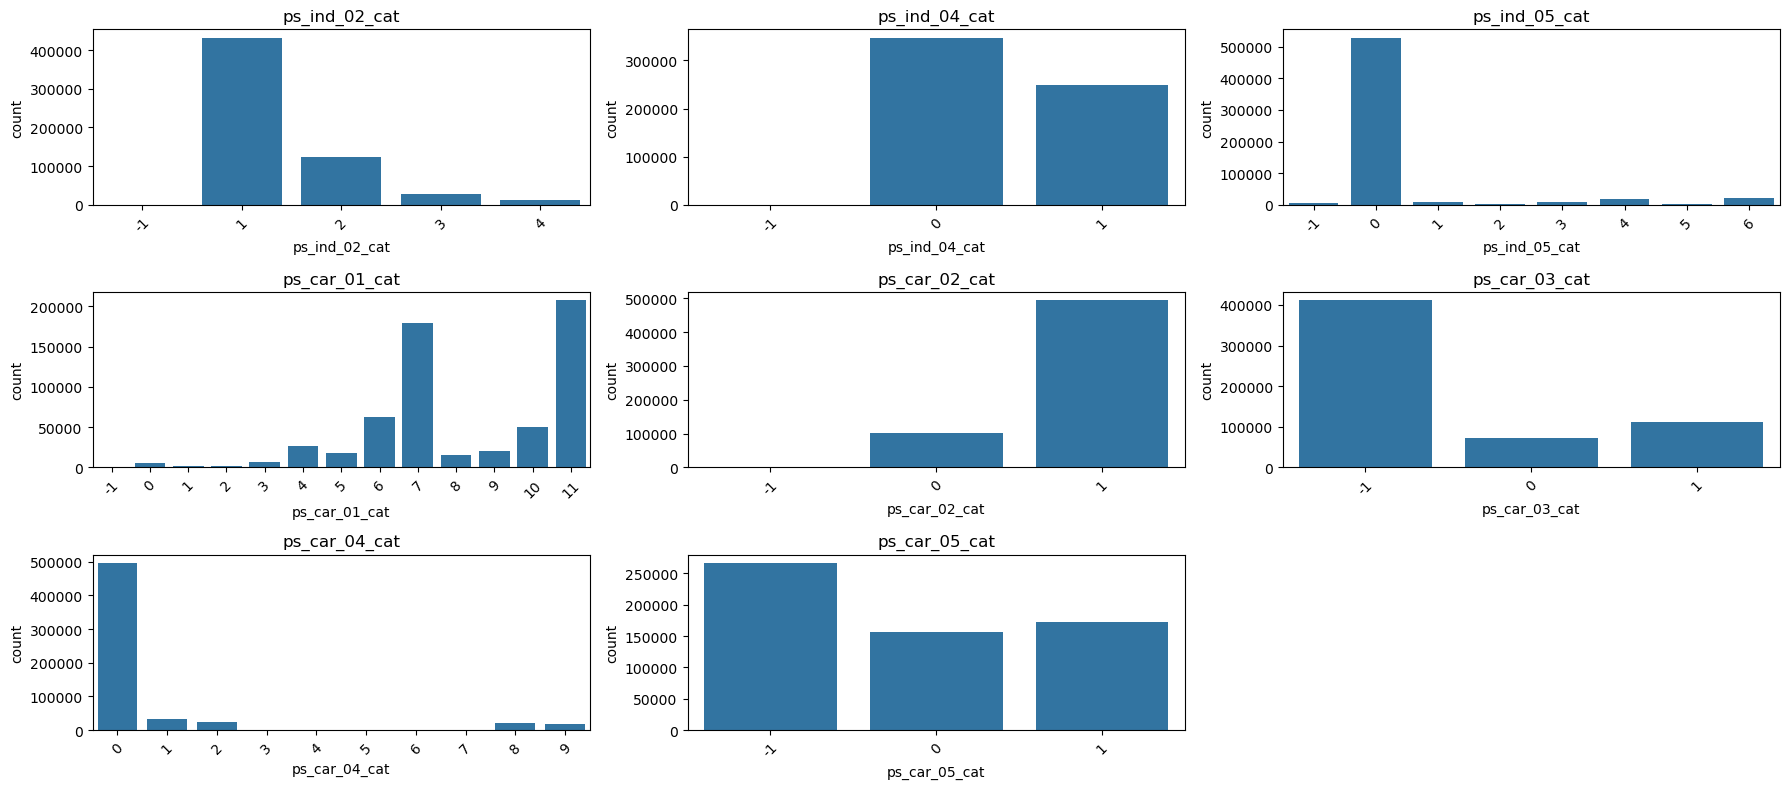

In [11]:
# Visualize categorical features

import matplotlib.pyplot as plt
import seaborn as sns

# First 8 categorical features for plotting
plot_features = cat_features[:8]

# Set up subplots (3 rows, 3 columns)
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(18, 8))

# Flatten axes for easy iteration
axes = axes.flatten()

for i, col in enumerate(plot_features):
    sns.countplot(x=col, data=df_train, ax=axes[i])
    axes[i].set_title(f'{col}')
    axes[i].tick_params(axis='x', rotation=45)

# Turn off the extra empty subplot if any
for j in range(len(plot_features), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


#### Univariate analysis of numeric features

In [12]:
# Analyze numeric features
df_train[num_features].describe().T 

,count,mean,std,min,25%,50%,75%,max
ps_ind_01,595212.0,1.900378,1.983789,0.000000,0.000000,1.000000,3.000000,7.000000
ps_ind_03,595212.0,4.423318,2.699902,0.000000,2.000000,4.000000,6.000000,11.000000
ps_ind_14,595212.0,0.012451,0.127545,0.000000,0.000000,0.000000,0.000000,4.000000
ps_ind_15,595212.0,7.299922,3.546042,0.000000,5.000000,7.000000,10.000000,13.000000
ps_reg_01,595212.0,0.610991,0.287643,0.000000,0.400000,0.700000,0.900000,0.900000
ps_reg_02,595212.0,0.439184,0.404264,0.000000,0.200000,0.300000,0.600000,1.800000
ps_reg_03,595212.0,0.551102,0.793506,-1.000000,0.525000,0.720677,1.000000,4.037945
ps_car_11,595212.0,2.346072,0.832548,-1.000000,2.000000,3.000000,3.000000,3.000000
ps_car_12,595212.0,0.379945,0.058327,-1.000000,0.316228,0.374166,0.400000,1.264911
ps_car_13,595212.0,0.813265,0.224588,0.250619,0.670867,0.765811,0.906190,3.720626


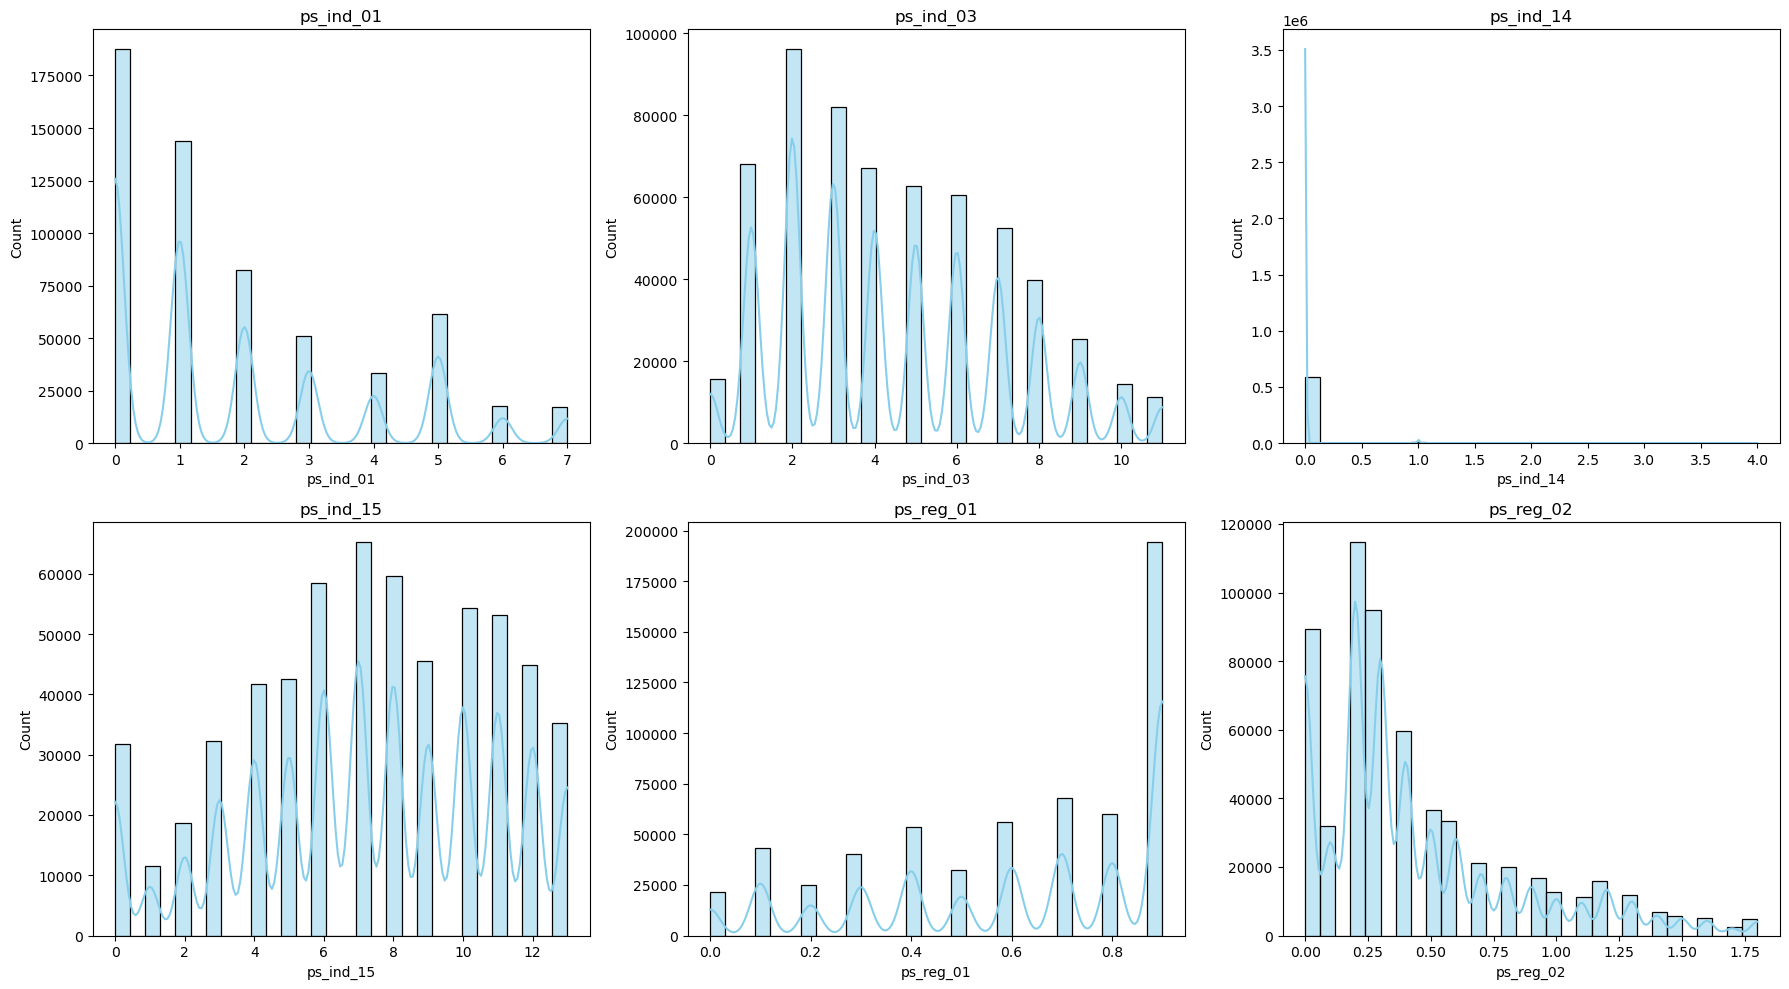

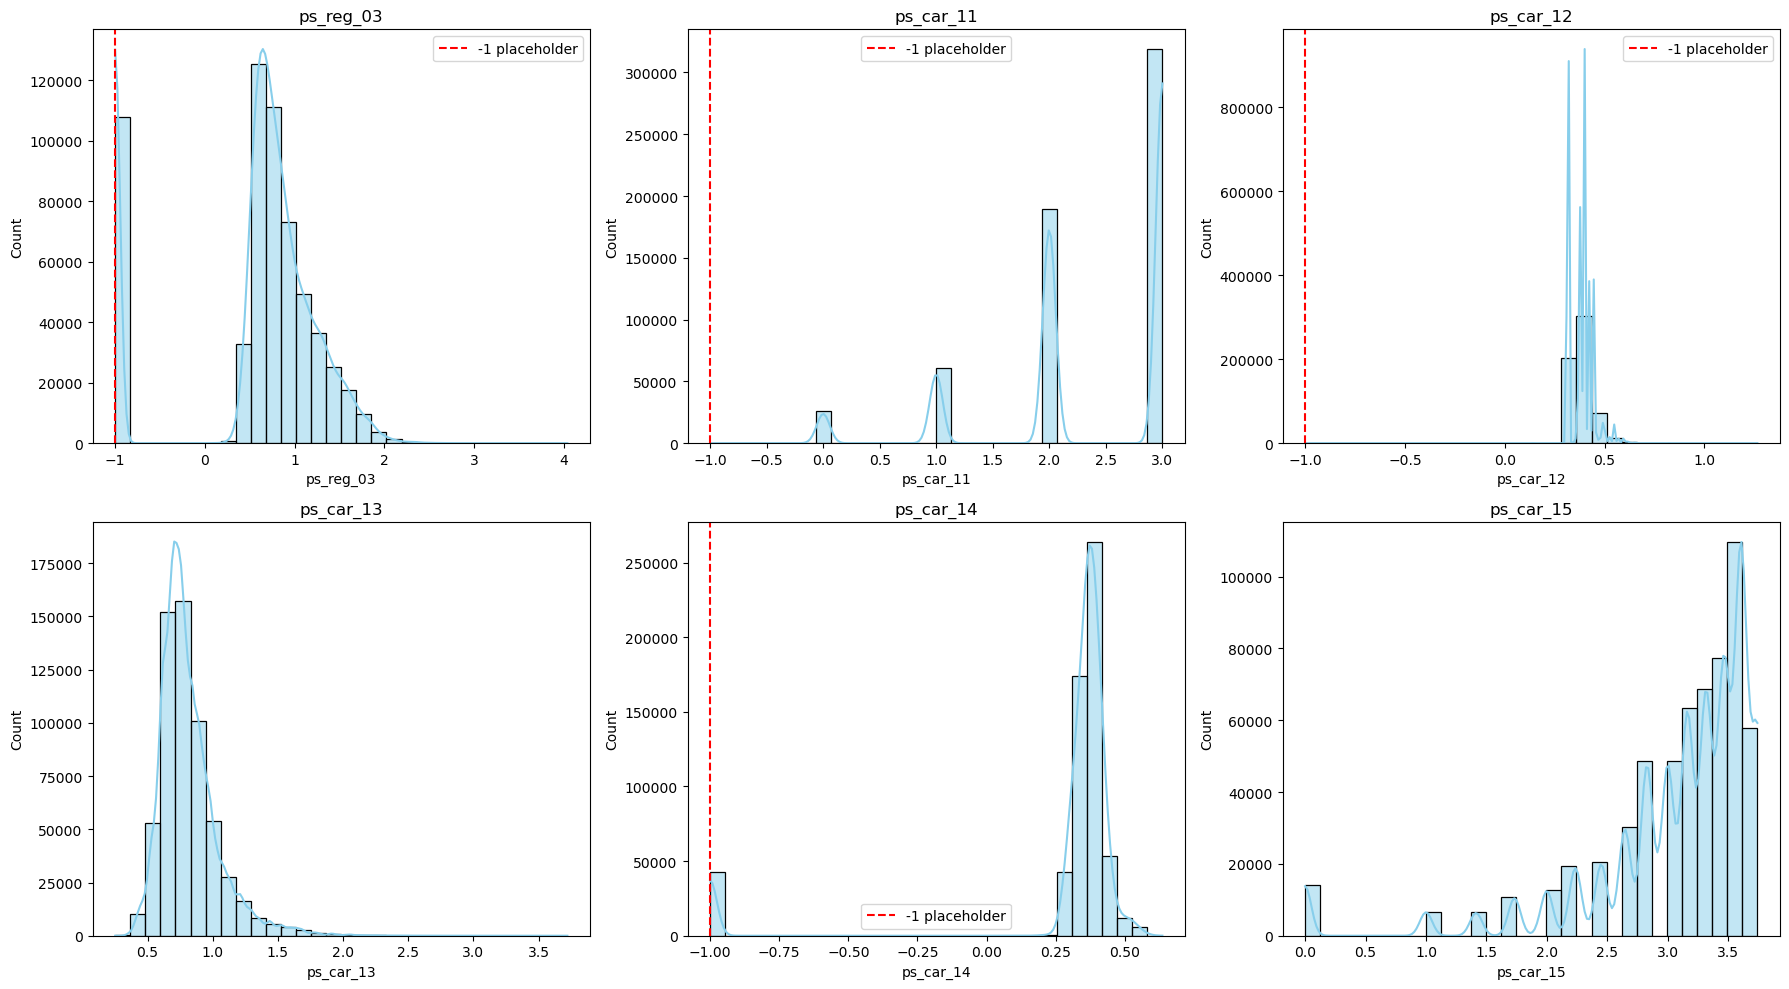

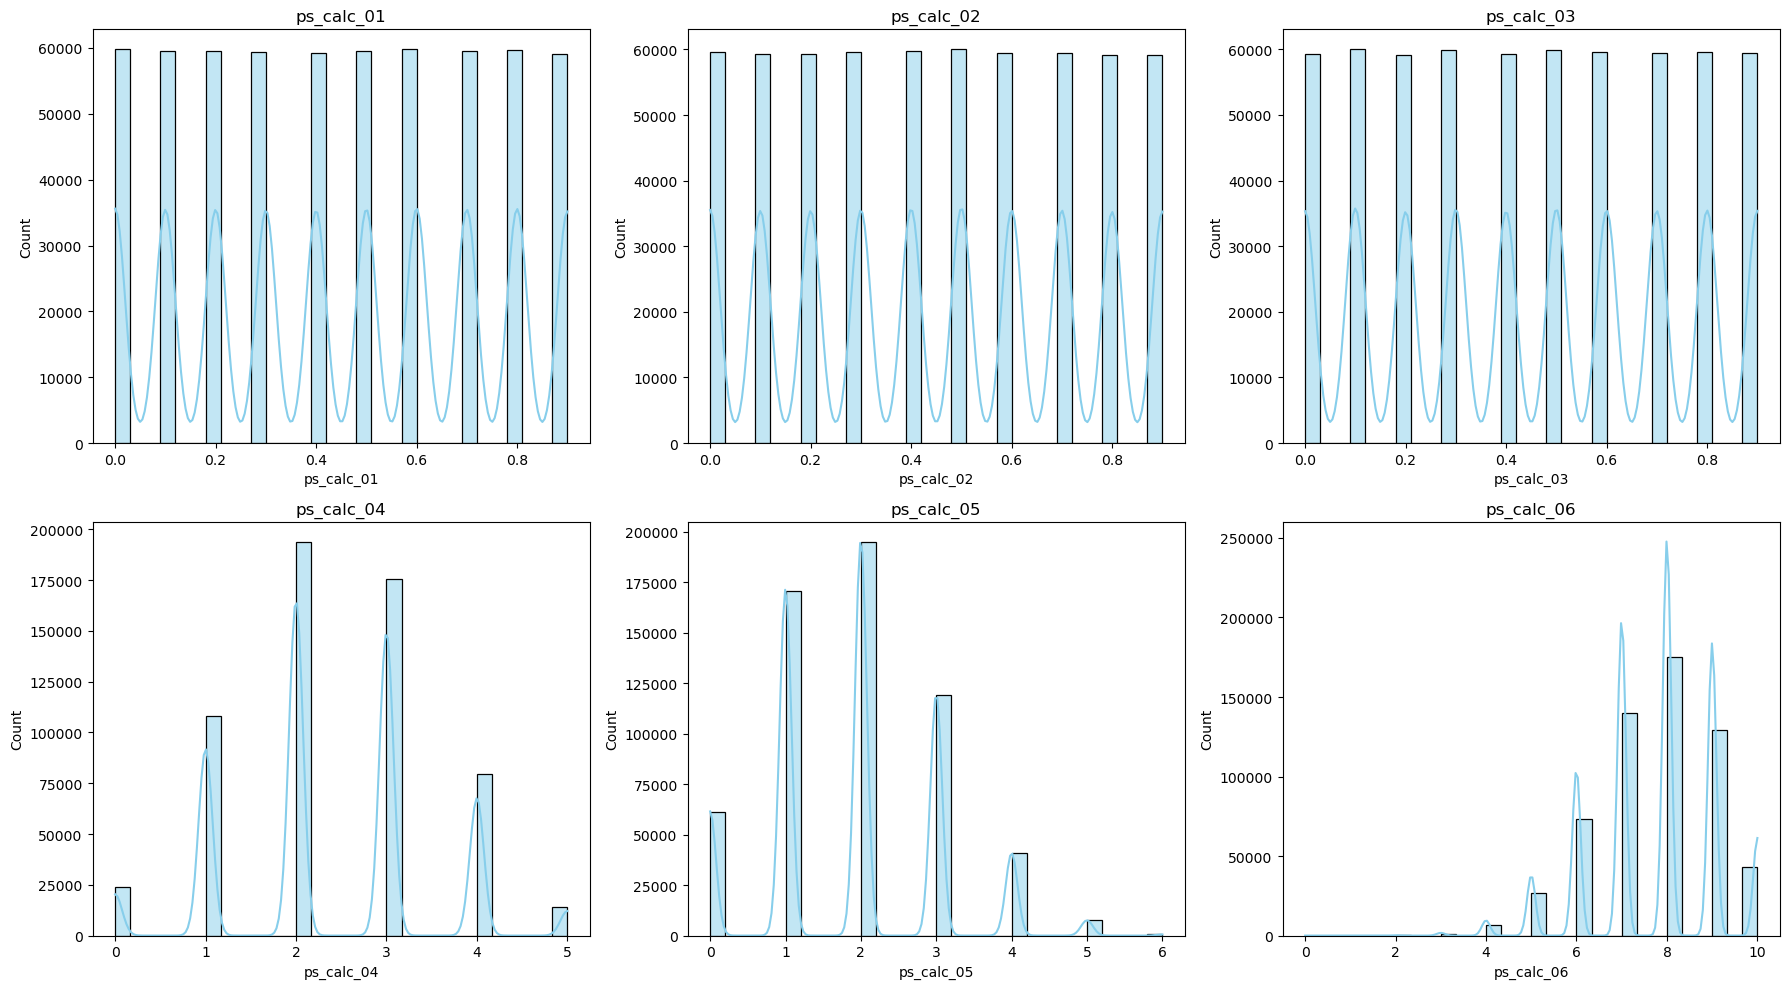

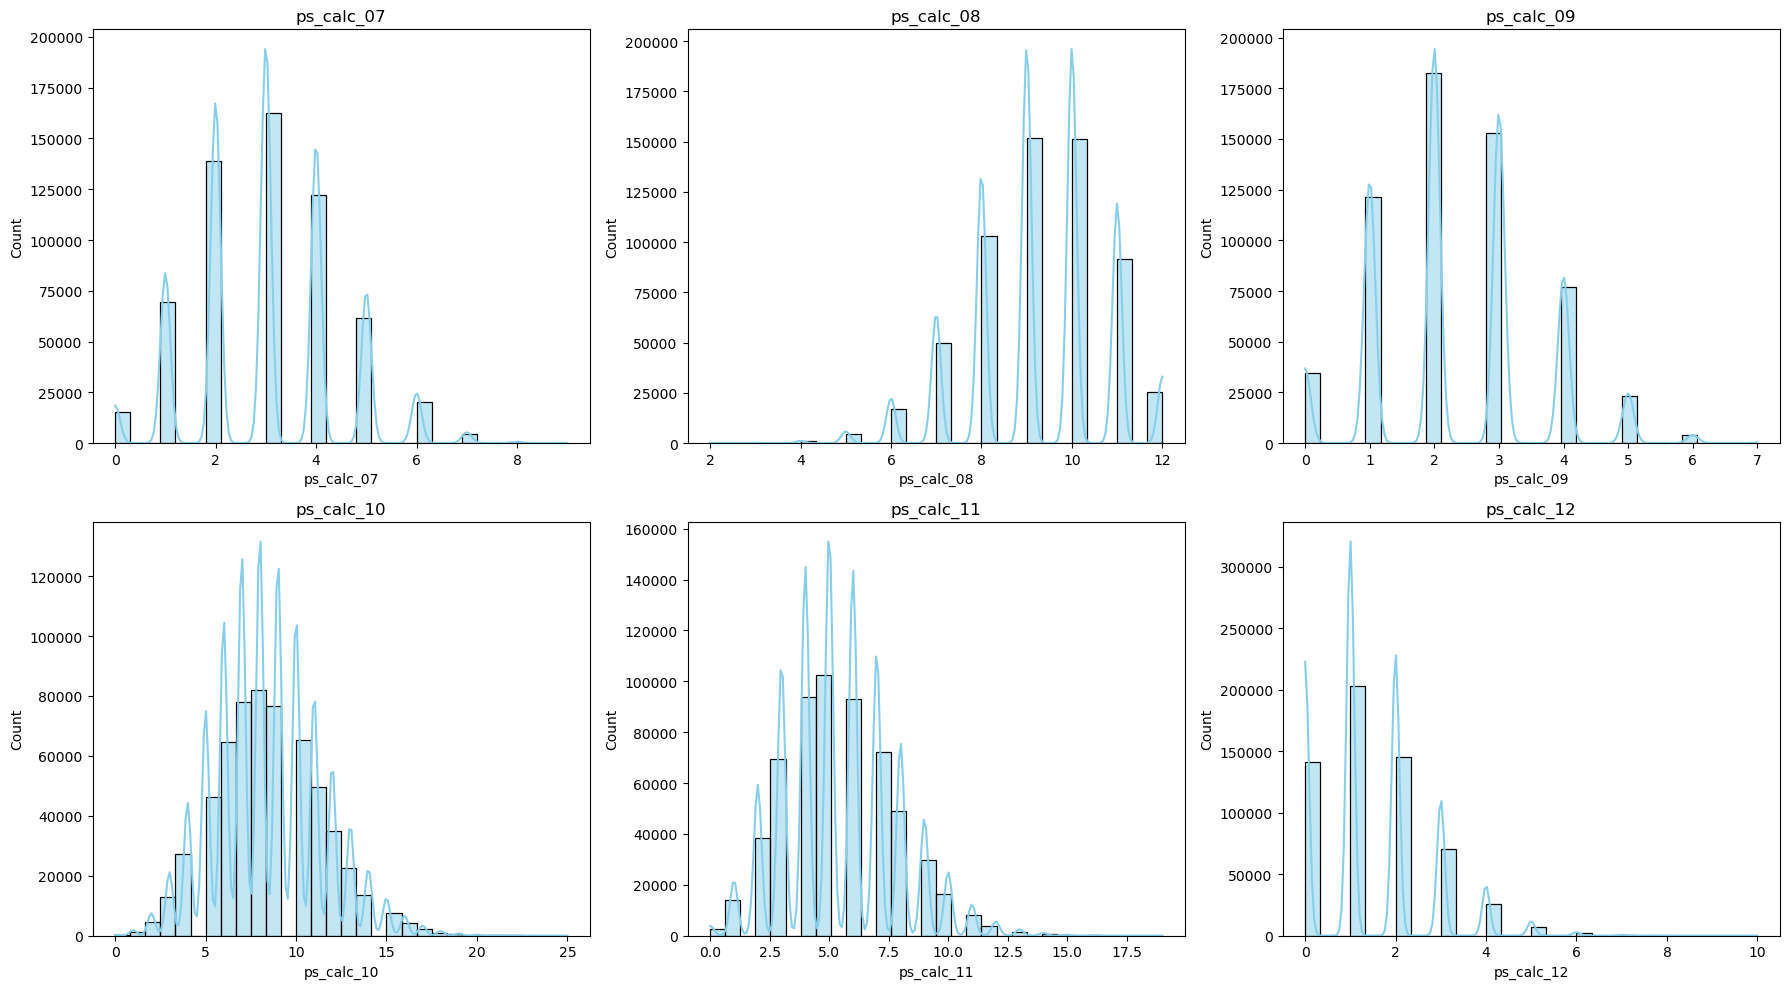

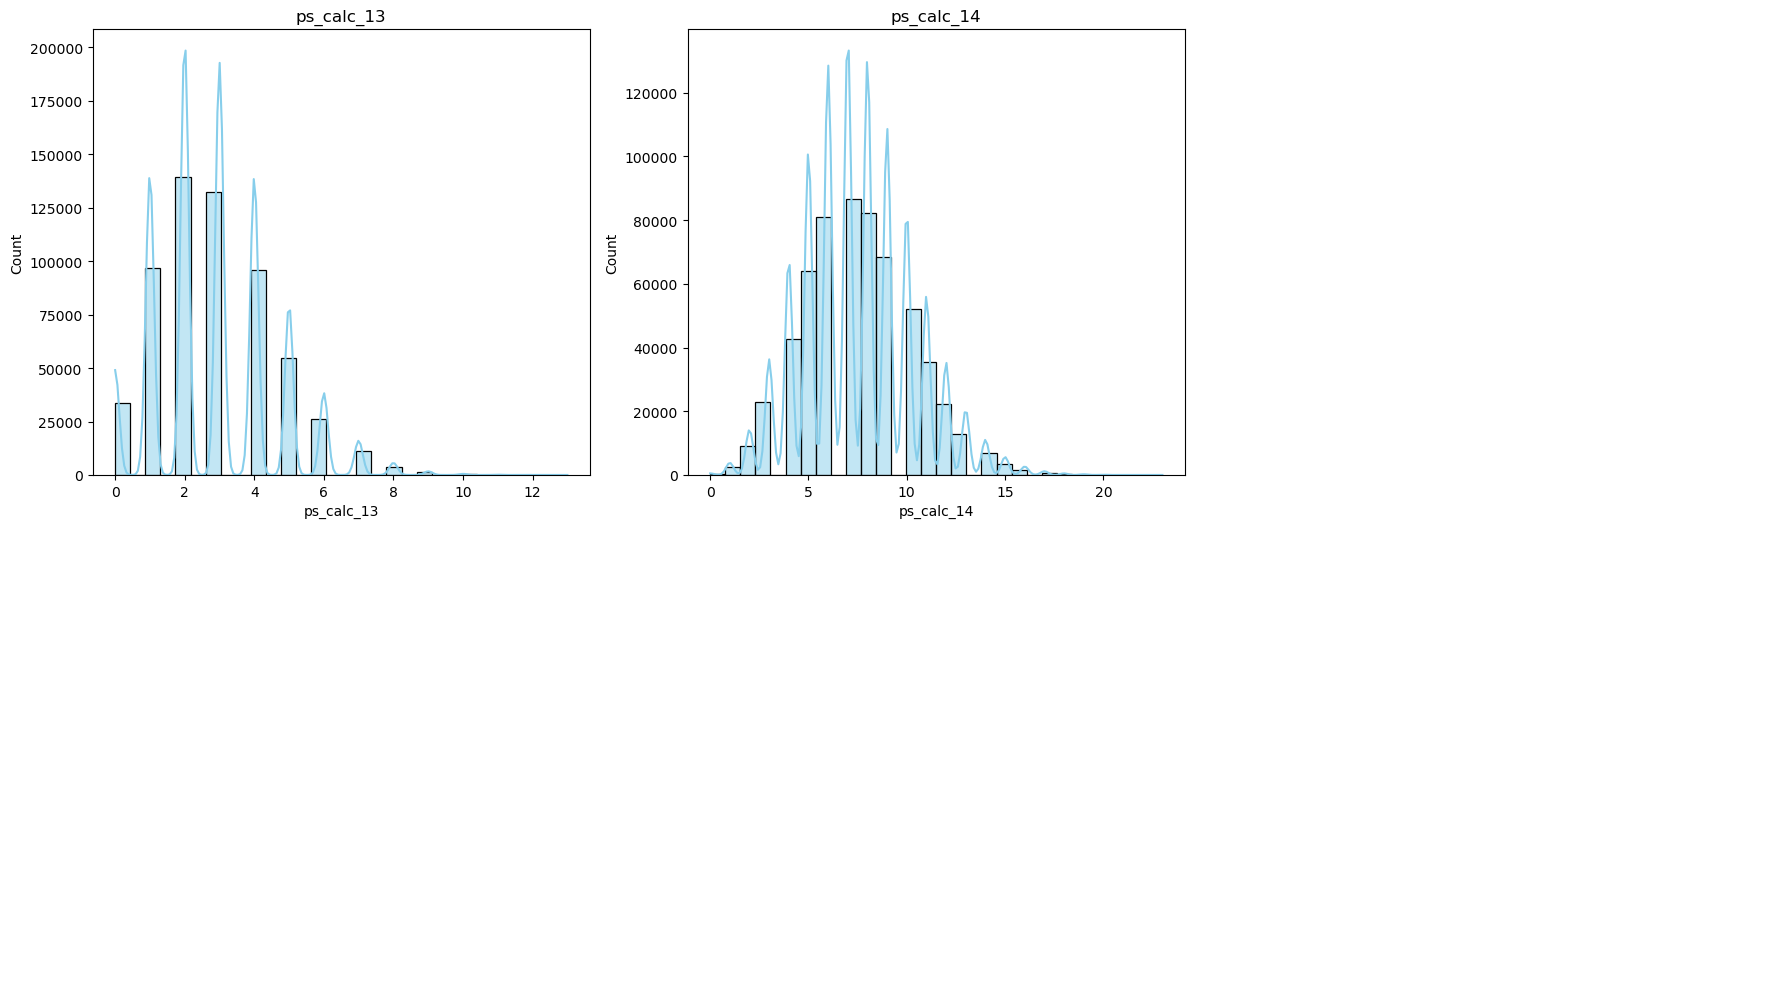

In [13]:
# Visualize numeric features
import matplotlib.pyplot as plt
import seaborn as sns


# Plot in chunks (6 features per figure)
chunk_size = 6

for i in range(0, len(num_features), chunk_size):
    chunk = num_features[i:i+chunk_size]
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
    axes = axes.flatten()
    
    for j, col in enumerate(chunk):
        sns.histplot(df_train[col], bins=30, kde=True, ax=axes[j], color='skyblue')
        axes[j].set_title(col)
        
        # Highlight possible outliers / special values (-1)
        if (df_train[col] < 0).any():
            axes[j].axvline(x=-1, color='red', linestyle='--', label='-1 placeholder')
            axes[j].legend()
    
    # Turn off extra axes if chunk < 6
    for k in range(len(chunk), len(axes)):
        axes[k].axis('off')
    
    plt.tight_layout()
    plt.show()


**Low-variance features:** ps_ind_14 (almost all 0) - candidate for removal or special handling.

**Skewed features:** Many features are right-skewed (mean > median), may benefit from log or sqrt transformation before modeling.

**Ranges differ:** Some features are normalized (0–1) like ps_car_12, ps_car_13 while others are small integers (ps_ind_01, ps_calc_04).

So scaling may be needed for ML models like Logistic Regression, KNN, or Neural Networks.

### Step4: Detect low-variance / constant features

In [14]:
# Identify low-variance features
# For binary and categorical features, check if almost all values are the same
low_var_bin_cat = []
for col in bin_features + cat_features:
    prop = df_train[col].value_counts(normalize=True).max()  # proportion of most frequent value
    if prop > 0.99:  # >99% same value
        low_var_bin_cat.append(col)

print("Low-variance binary/categorical features:", low_var_bin_cat)


Low-variance binary/categorical features: ['ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_12_bin', 'ps_ind_13_bin', 'ps_car_10_cat']


- The analysis identified five features `(ps_ind_10_bin, ps_ind_11_bin, ps_ind_12_bin, ps_ind_13_bin, ps_car_10_cat)` where over 99% of the values are the same.
- Such features have very low variability and are unlikely to provide meaningful predictive information.

Since the target is highly imbalanced, these features may still contain rare signals, but in general, they are good candidates for removal to reduce noise and simplify the model.


### Step5: Bivariate Analysis

#### Binary feature vs target comparison

In [15]:
# Analyze binary features vs target

# Create a summary table showing mean target value for each binary feature
bin_summary = df_train.groupby('target')[bin_features].mean().T

bin_summary.columns = ['Target=0', 'Target=1']

bin_summary['Diff'] = bin_summary['Target=1'] - bin_summary['Target=0']
bin_summary.sort_values('Diff', ascending=False, inplace=True)

bin_summary.head(17) 


,Target=0,Target=1,Diff
ps_ind_07_bin,0.254125,0.333917,0.079793
ps_ind_17_bin,0.118730,0.183230,0.064500
ps_ind_08_bin,0.162975,0.188946,0.025971
ps_ind_18_bin,0.153127,0.161888,0.008761
ps_ind_12_bin,0.009292,0.013322,0.004030
ps_calc_16_bin,0.627782,0.629391,0.001609
ps_calc_18_bin,0.287133,0.288467,0.001334
ps_ind_11_bin,0.001676,0.002120,0.000445
ps_ind_13_bin,0.000933,0.001337,0.000404
ps_ind_10_bin,0.000366,0.000553,0.000187


We perform **bivariate analysis of binary features with respect to the target**.

For each feature, we compute the proportion of rows where the feature=1 in Target=0 vs Target=1.  
The Diff indicates how strongly the feature separates the two classes.

- Higher proportion in target=1 (positive Diff) -> feature=1 is associated with higher probability of claim (more likely to file a claim).

- Higher proportion in target=0 (negative Diff) -> feature=0 is associated with higher probability of claim, because feature=1 is less frequent among claims(i.e most of the feature =1 falls under target=0).

- Small differences (Diff close to 0) -> feature doesn’t differentiate the target much.

- Features with larger differences are likely more useful predictors.

For good predictors, we expect differences like 0.05–0.1+

Only a few binary features (**ps_ind_07_bin**, **ps_ind_17_bin**) show clear separation between target=0 and target=1, so they are likely useful predictors.

Many others show almost no separation - they add little value on their own, but could still help in combinations.

Very rare features may not contribute much, unless the dataset is huge.

#### Bivariate binary analysis using chi-square and Cramér’s V

In [16]:
# Bivariate categorical analysis using chi-square and Cramér’s V
from utils import categorical_feature_analysis

# Here we pass a lower drop threshold (0.02) because the dataset is imbalanced and some features are rare so tolerate lower Cramér's V values
bin_summary_df = categorical_feature_analysis(
    df_train, 
    cat_cols=bin_features,  # concatenate lists, not wrap in []
    target_col='target', 
    drop_threshold=0.02, # lower threshold to drop features with very low association
    p_value_threshold=0.05
)

print("Summary of binary feature analysis:")
bin_summary_df

Summary of binary feature analysis:


,Feature,Chi2_p_value,Cramers_V,Drop
9,ps_ind_17_bin,0.000000,0.0370,False
1,ps_ind_07_bin,0.000000,0.0342,False
0,ps_ind_06_bin,0.000000,0.0340,False
8,ps_ind_16_bin,0.000000,0.0278,False
2,ps_ind_08_bin,0.000000,0.0131,True
3,ps_ind_09_bin,0.000000,0.0082,True
6,ps_ind_12_bin,0.000000,0.0078,True
10,ps_ind_18_bin,0.000457,0.0045,True
7,ps_ind_13_bin,0.074146,0.0023,True
5,ps_ind_11_bin,0.138717,0.0019,True


- p-value tells if there’s a statistically significant association with the target.

- Cramér’s V measures the strength of the association (general guideline: 0 - no association, 0.1 - weak, 0.3 - moderate, 0.5 - strong, 1 - perfect association).

        Note: In this dataset, the target is highly imbalanced and some categories are rare, so Cramér’s V values are naturally lower. Therefore, even small values (e.g., 0.02–0.05) can indicate a potentially useful feature.

- If p-value is < 0.05 and Cramér’s V is reasonably high, keep this feature (handle missing values smartly). Otherwise, it may be safe to drop.

Many low-variance binary features identified earlier (**ps_ind_10_bin, ps_ind_11_bin, ps_ind_12_bin, ps_ind_13_bin**) show very low Cramér’s V (<0.02) and/or non-significant Chi-square p-values, indicating minimal association with the target.

This confirms the low predictive power highlighted in the Low-Variance Features section.

A few binary features (**ps_ind_06_bin, ps_ind_07_bin, ps_ind_16_bin, ps_ind_17_bin**) have moderate Cramér’s V (>0.02) and significant p-values, suggesting they may provide useful signal despite class imbalance.

Conclusion: Most low-variance features can be considered for removal to reduce noise and simplify the model, while retaining features with moderate association for potential predictive value.

#### Bivariate categorical analysis using chi-square and Cramér’s V

In [17]:
# Bivariate categorical analysis using chi-square and Cramér’s V
from utils import categorical_feature_analysis

# Here we pass a lower drop threshold (0.02) because the dataset is imbalanced and some categories are rare so tolerate lower Cramér's V values
summary_df = categorical_feature_analysis(
    df_train, 
    cat_cols=cat_features,  # concatenate lists, not wrap in []
    target_col='target', 
    drop_threshold=0.02, 
    p_value_threshold=0.05
)

print("Summary of categorical feature analysis:")
summary_df

Summary of categorical feature analysis:


,Feature,Chi2_p_value,Cramers_V,Drop
13,ps_car_11_cat,0.000000,0.0500,False
2,ps_ind_05_cat,0.000000,0.0435,False
3,ps_car_01_cat,0.000000,0.0412,False
6,ps_car_04_cat,0.000000,0.0382,False
8,ps_car_06_cat,0.000000,0.0374,False
9,ps_car_07_cat,0.000000,0.0367,False
5,ps_car_03_cat,0.000000,0.0324,False
4,ps_car_02_cat,0.000000,0.0315,False
11,ps_car_09_cat,0.000000,0.0281,False
1,ps_ind_04_cat,0.000000,0.0249,False


- p-value tells if there’s a statistically significant association with the target.

- Cramér’s V measures the strength of the association (general guideline: 0 - no association, 0.1 - weak, 0.3 - moderate, 0.5 - strong, 1 - perfect association).

        Note: In this dataset, the target is highly imbalanced and some categories are rare, so Cramér’s V values are naturally lower. Therefore, even small values (e.g., 0.02–0.05) can indicate a potentially useful feature.

- If p-value is < 0.05 and Cramér’s V is reasonably high, keep this feature (handle missing values smartly). Otherwise, it may be safe to drop.

- ps_car_03_cat (69% missing) and ps_car_05_cat (45% missing) have Cramér’s V values above our conservative threshold (0.02) and extremely small p-values (0.0000, < 0.05), indicating a statistically significant association with the target. Therefore, these features should not be removed despite the high missing rates; imputation is recommended.

- ps_ind_02_cat and ps_car_10_cat show very low Cramér’s V or non-significant p-values, indicating minimal predictive power. These features can be safely dropped.

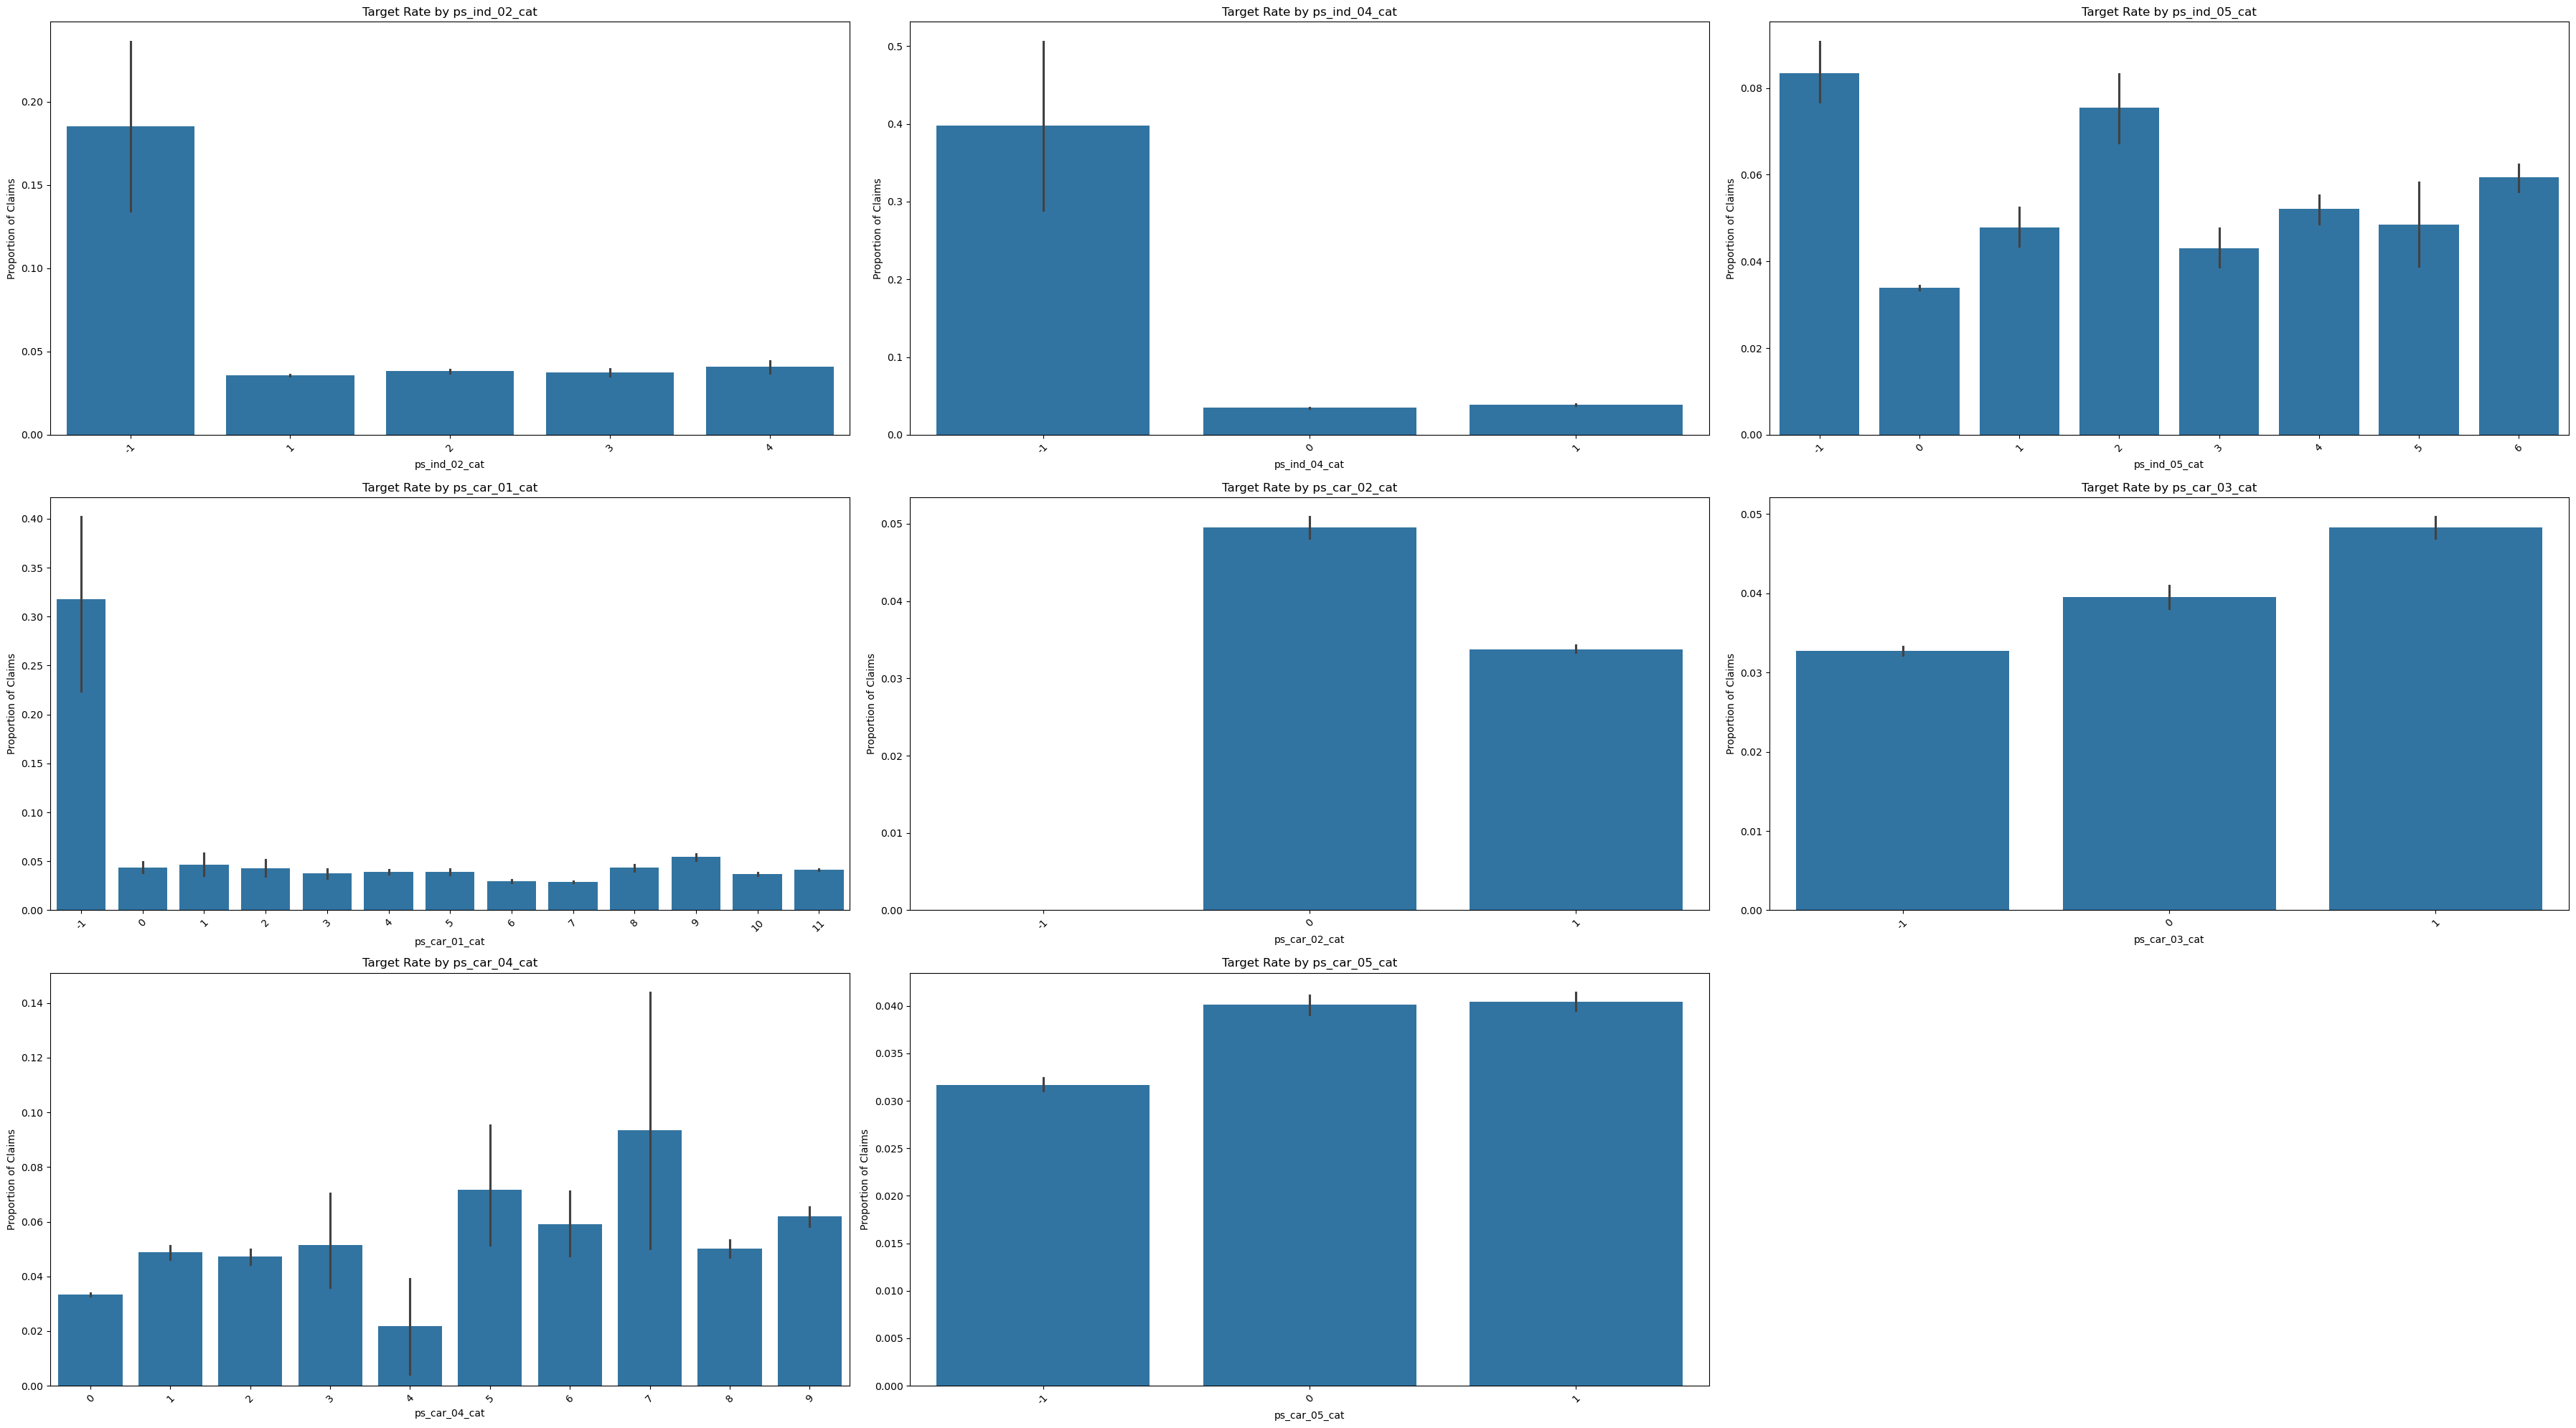

In [18]:
# Visualize category features vs target
import matplotlib.pyplot as plt
import seaborn as sns

top_cat_features = cat_features[:8]  # choose first 8 for visualization
n_rows = 3
n_cols = 3  # 2*3 layout (one extra empty subplot is fine)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(36, 20))
axes = axes.flatten()

for i, col in enumerate(top_cat_features):
    sns.barplot(x=col, y='target', data=df_train, ax=axes[i]) # y='target' automatically calculates mean target per category
    axes[i].set_title(f'Target Rate by {col}')
    axes[i].set_ylabel('Proportion of Claims')
    axes[i].set_xlabel(col)
    axes[i].tick_params(axis='x', rotation=45) # Rotate x labels for better readability

# Hide unused subplot if any
for j in range(i+1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()


X-axis (x=col) - the categories of the feature (e.g., ps_ind_02_cat might have values -1, 1, 2, 3 etc).

Y-axis (y='target') - the mean of the target for each category.
- Since target is 0 or 1, the mean = proportion of claims in that category.
- Example: if 100 rows have category 2 and 10 of them have target=1, the bar height = 10/100 = 0.1

Each bar represents the claim rate for that category.

- Taller bars has higher probability of claims for that category.

- Shorter bars has lower probability of claims.

#### Numeric features vs Target

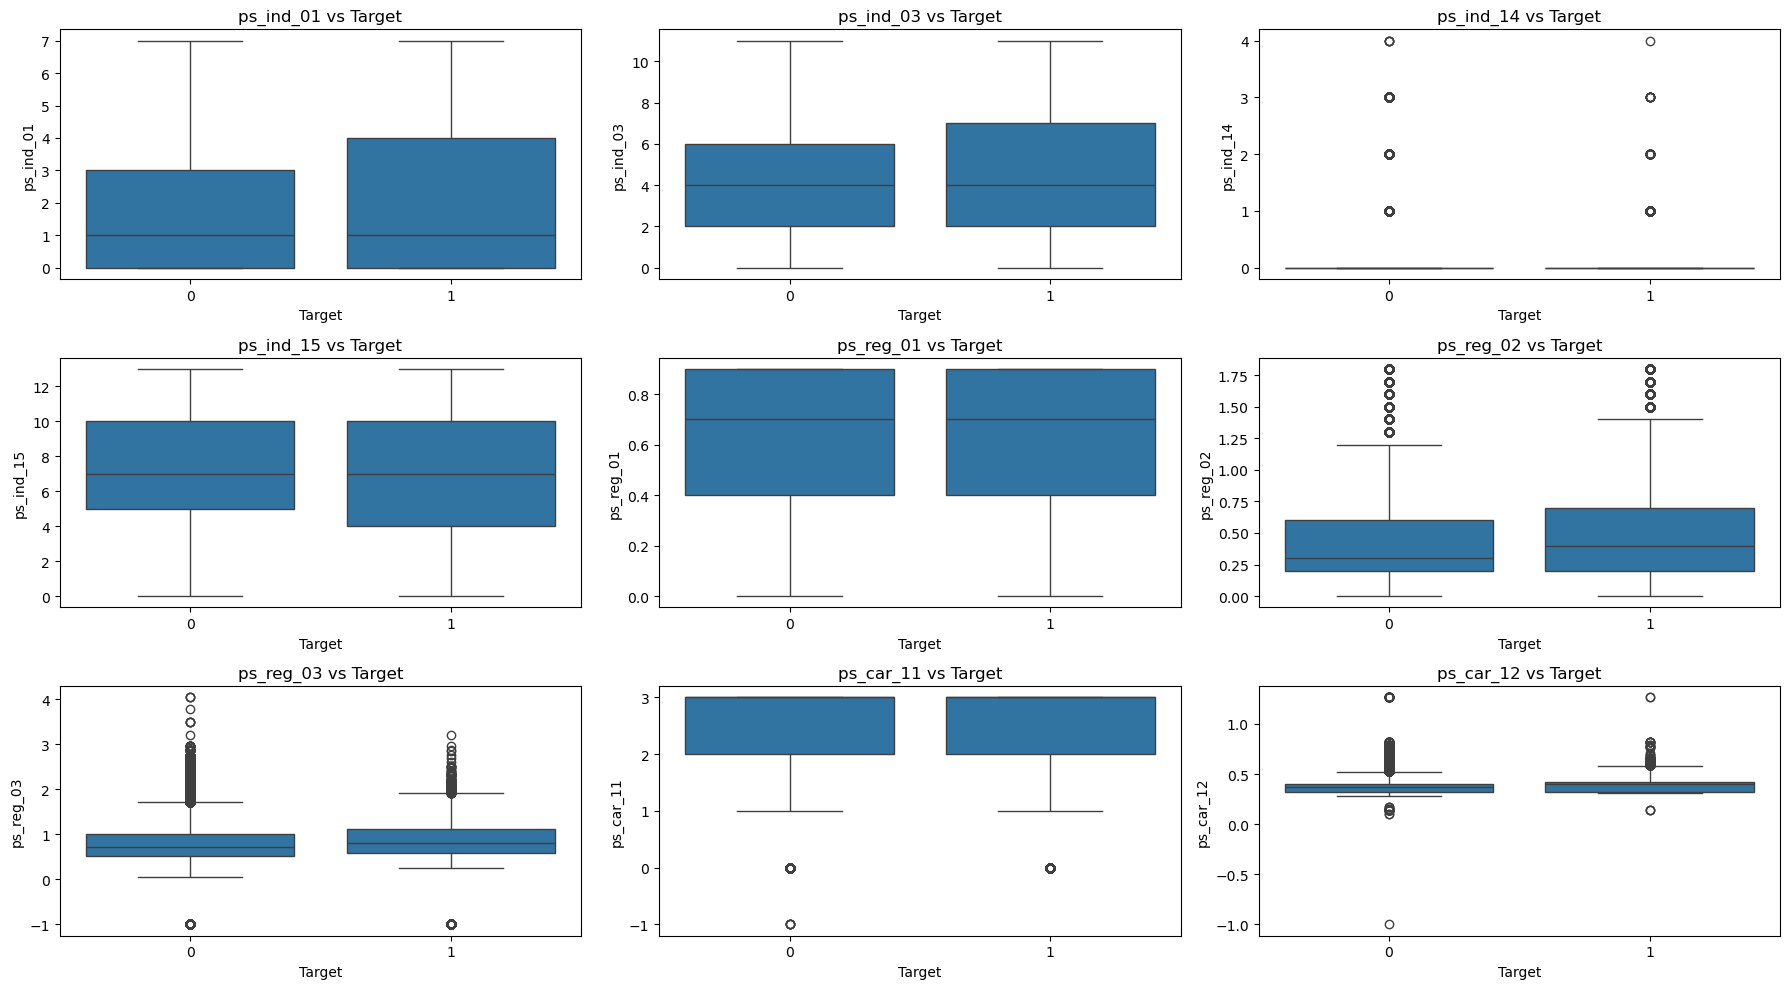

In [19]:
# Bivariate analysis: Numeric features vs Target
import matplotlib.pyplot as plt
import seaborn as sns

# Choose top 9 numeric features for visualization (to avoid overcrowding)
top_num_features = num_features[:9]
n_rows = 3
n_cols = 3
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 10))
axes = axes.flatten()

for i, col in enumerate(top_num_features):
    sns.boxplot(x='target', y=col, data=df_train, ax=axes[i])
    axes[i].set_title(f'{col} vs Target')
    axes[i].set_xlabel('Target')
    axes[i].set_ylabel(col)

plt.tight_layout()
plt.show()


X-axis - target (0 = no claim, 1 = claim). Each target class has its own box.

Y-axis - values of the numeric feature (e.g- ps_ind_01).

The box shows the interquartile range (IQR) — the middle 50% of values.
- Bottom of the box - 25th percentile (Q1)
- Top of the box - 75th percentile (Q3)
- The line in the middle of the box is the median (50th percentile) of the feature for that target class.

Compare medians - if the median is higher for target=1, higher values may indicate higher probability of claims.

Compare boxes - if boxes mostly overlap - feature doesn’t separate classes well. If they barely overlap - feature may be predictive.

Look for outliers - can indicate extreme cases that may affect modeling.

The numeric features almost behaves like categorical features because most of them are quite balanced except for `ps_ind_14`.

### Step 6: Identify Correlation

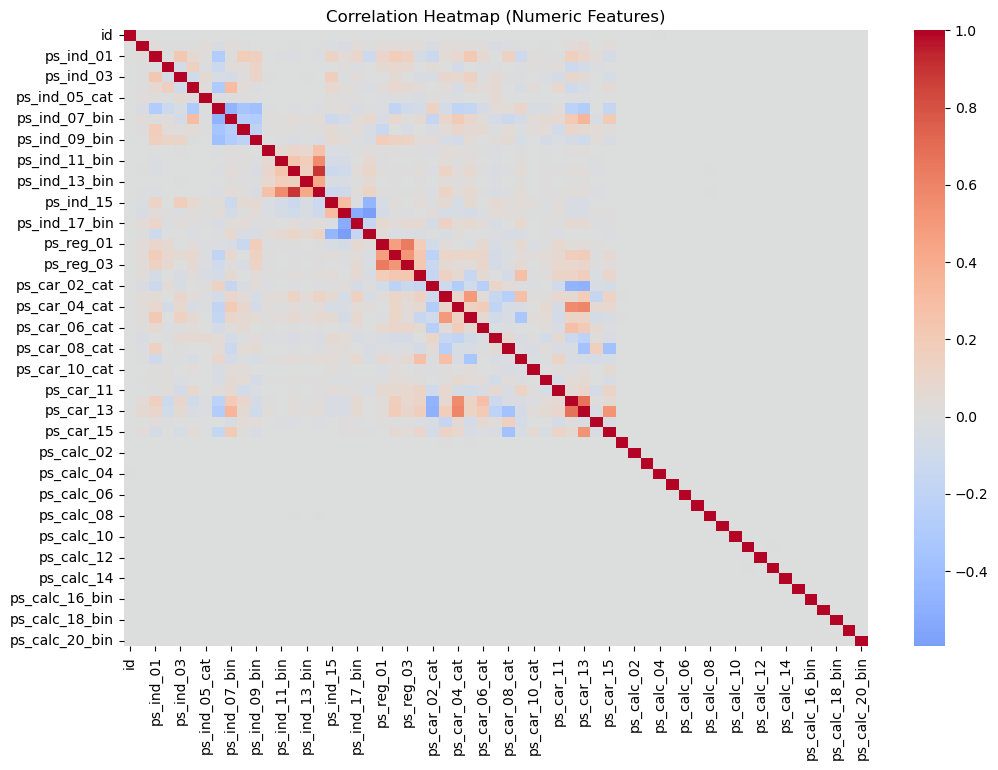

In [20]:
# Correlational analysis
import seaborn as sns
import matplotlib.pyplot as plt

# Compute correlation
corr = df_train.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=False, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap (Numeric Features)")
plt.show()


Most features shows little to no significant correlation, suggesting that the features can be considered independent.

## Preprocessing

### Step 1: Stratified sampling

In [21]:
df_train.shape

(595212, 59)

In [22]:
# Stratified sampling to create a smaller working dataset
from sklearn.model_selection import train_test_split

# df_train is the original dataset
# 'target' is the column we want to predict

# Fraction of data to keep for a small working sample
sample_frac = 0.05  # 5% of the dataset

# Stratified split to create a smaller sample while keeping the target class distribution
df_sample, df_rest = train_test_split(
    df_train,
    test_size=(1 - sample_frac),       # Remaining 95% goes into df_rest
    stratify=df_train['target'],       # Preserve class proportions in the sample
    random_state=42                     # Ensures reproducible split
)

# Check shape of the small sample
df_sample.shape


(29760, 59)

In [23]:
# Reset index after sampling 
df_sample.reset_index(drop=True, inplace=True) # This is important to avoid index issues later

### Step2: Removing Irrelevant and Low-Value Features

**Identify ID-like columns (unique identifiers)**

In [24]:
id_like_cols = [col for col in df_sample.columns if df_sample[col].nunique() == len(df_sample)]

print("ID-like columns:", id_like_cols)

ID-like columns: ['id']


**Drop the columns**

In [25]:
# Define columns to drop

# Columns identified for removal:
# - Low-variance binary features with minimal association to target
low_var_bin_drop = ['ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_12_bin', 'ps_ind_13_bin']

# - Categorical features with minimal predictive power based on Chi-square & Cramér's V
cat_drop = ['ps_ind_02_cat', 'ps_car_10_cat']

cols_to_drop = id_like_cols + low_var_bin_drop + cat_drop
# cols_to_drop = id_like_cols

print("Columns to drop:", cols_to_drop)
# Drop them safely
df_sample = df_sample.drop(columns=cols_to_drop, errors="ignore")

#  update category features list after dropping some columns
cat_features = [c for c in cat_features if c not in cols_to_drop]

# update binary features list after dropping some columns
bin_features = [c for c in bin_features if c not in cols_to_drop]

# Check new shape
df_sample.shape


Columns to drop: ['id', 'ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_12_bin', 'ps_ind_13_bin', 'ps_ind_02_cat', 'ps_car_10_cat']


(29760, 52)

### Step 3: Impute Features

**Numeric Imputation**

In [26]:
# Numeric Imputation

# Numeric columns with missing values
missing_num_cols = ['ps_reg_03', 'ps_car_14']

for col in missing_num_cols:
    median_val = df_sample.loc[df_sample[col] != -1, col].median() # here .loc means we are selecting rows where col != -1 and second col is the column we want the median of
    df_sample[col] = df_sample[col].replace(-1, median_val) # here we replace -1 with the median value we just calculated

**Category Imputation**

In [27]:
# Category Imputation

# Categorical columns with missing values
missing_cat_features = ["ps_car_03_cat", "ps_car_05_cat", "ps_car_07_cat","ps_ind_05_cat","ps_car_09_cat","ps_car_01_cat","ps_ind_04_cat","ps_car_02_cat"]
for col in missing_cat_features:
    mode_val = df_sample[col][df_sample[col] != -1].mode()[0]
    df_sample[col] = df_sample[col].replace(-1, mode_val)

In [28]:
# Re verify for missing values in each column
# Since in EDA we saw that there were no binary features with missing values, so we have skipped the imputation of them.
missing = (df_sample == -1).sum()
missing = missing[missing > 0].sort_values(ascending=False)

# Convert to percentage
missing_percent = (missing / len(df_sample)) * 100

missing_df = pd.DataFrame({
    'Missing Count': missing,
    'Missing %': missing_percent.round(2)
})
print(missing_df)


Empty DataFrame
Columns: [Missing Count, Missing %]
Index: []


### Step 4: Feature Scaling
Since KNN is sensitive to the scale of data, we will standardize our features.

#### Scale numeric features

In [29]:
# Scale only numeric features
from sklearn.preprocessing import StandardScaler

# Standardize features with mean=0 and std=1
scaler = StandardScaler()

df_sample[num_features] = scaler.fit_transform(df_sample[num_features])
# Learns the mean and std of each column (fit) and then transforms the data (transform) to have mean=0 and std=1

df_sample[num_features].head()

,ps_ind_01,ps_ind_03,ps_ind_14,ps_ind_15,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_11,ps_car_12,ps_car_13,...,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14
0,0.049521,0.586438,-0.096818,0.759804,-0.731872,0.162035,0.755366,-0.422062,2.865798,3.835472,...,2.721392,-1.274998,1.403672,-0.832515,0.531115,-0.837682,0.674334,-0.370778,-1.094677,-1.650272
1,-0.456748,0.216582,7.253482,0.759804,-0.731872,-1.087424,-0.212768,-0.422062,2.548533,2.083889,...,0.971100,1.730522,-1.398822,-0.832515,-0.273670,0.534271,0.674334,0.458187,-0.502497,0.170016
2,-0.963016,-1.262843,-0.096818,1.041055,-0.731872,-1.087424,1.247590,-1.626452,-1.088761,-0.927337,...,0.095954,0.227762,1.403672,-0.149445,-0.273670,1.220248,0.674334,-0.370778,-1.094677,0.898131
3,-0.456748,0.216582,-0.096818,-0.083950,0.662504,-0.587640,-0.611525,-1.626452,-1.091463,-0.917113,...,0.095954,0.979142,0.002425,-1.515586,2.945471,0.534271,0.244305,-0.370778,-1.094677,-0.558099
4,-0.456748,-0.153274,-0.096818,1.041055,0.662504,-0.087857,-0.520015,0.782327,-0.099024,-0.205239,...,0.095954,0.979142,0.703048,1.216697,-0.273670,-0.494694,-1.475813,-1.199742,-0.502497,-1.650272


#### Encode categorical features

In [30]:
# Encode categorical features
df_sample = pd.get_dummies(df_sample, columns=cat_features, drop_first=True, dtype=int) # here dtype=int ensures the new columns are of integer type

In [31]:
encoded_cat_columns = [col for col in df_sample.columns if any(cat in col for cat in cat_features)]

print("One-hot encoded categorical columns:", encoded_cat_columns)

One-hot encoded categorical columns: ['ps_ind_04_cat_1', 'ps_ind_05_cat_1', 'ps_ind_05_cat_2', 'ps_ind_05_cat_3', 'ps_ind_05_cat_4', 'ps_ind_05_cat_5', 'ps_ind_05_cat_6', 'ps_car_01_cat_1', 'ps_car_01_cat_2', 'ps_car_01_cat_3', 'ps_car_01_cat_4', 'ps_car_01_cat_5', 'ps_car_01_cat_6', 'ps_car_01_cat_7', 'ps_car_01_cat_8', 'ps_car_01_cat_9', 'ps_car_01_cat_10', 'ps_car_01_cat_11', 'ps_car_02_cat_1', 'ps_car_03_cat_1', 'ps_car_04_cat_1', 'ps_car_04_cat_2', 'ps_car_04_cat_3', 'ps_car_04_cat_4', 'ps_car_04_cat_5', 'ps_car_04_cat_6', 'ps_car_04_cat_7', 'ps_car_04_cat_8', 'ps_car_04_cat_9', 'ps_car_05_cat_1', 'ps_car_06_cat_1', 'ps_car_06_cat_2', 'ps_car_06_cat_3', 'ps_car_06_cat_4', 'ps_car_06_cat_5', 'ps_car_06_cat_6', 'ps_car_06_cat_7', 'ps_car_06_cat_8', 'ps_car_06_cat_9', 'ps_car_06_cat_10', 'ps_car_06_cat_11', 'ps_car_06_cat_12', 'ps_car_06_cat_13', 'ps_car_06_cat_14', 'ps_car_06_cat_15', 'ps_car_06_cat_16', 'ps_car_06_cat_17', 'ps_car_07_cat_1', 'ps_car_08_cat_1', 'ps_car_09_cat_1', 'p

### Step5: Split the Data

In [32]:
from sklearn.model_selection import train_test_split

# Separate input features(X) and target variable (y)
X = df_sample.drop('target',axis=1)
y = df_sample['target']

# Split data into training (80%) and testing (20%) sets
# - random_state ensures reproducible split
# - stratify keeps class proportions same in train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

## Model Training and evaluation with the imbalanced data

### The metric trap


When working with imbalanced datasets, simple metrics like accuracy can be misleading. Even with well-engineered features, a model that always predicts the majority class can still show a high accuracy, while completely failing to capture the minority class.

Let’s see this effect in action before applying any sampling or balancing:

In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from utils import train_and_evaluate_model

# Logistic Regression
lr_metrics = train_and_evaluate_model(LogisticRegression(max_iter=1000), X_train, X_test, y_train, y_test)
print("Logistic Regression:", lr_metrics)

# KNN
knn_metrics = train_and_evaluate_model(KNeighborsClassifier(n_neighbors=5), X_train, X_test, y_train, y_test)
print("KNN:", knn_metrics)

Logistic Regression: {'accuracy': '96.35%', 'precision': '0.00%', 'recall': '0.00%', 'f1': '0.00%', 'roc_auc': '50.00%'}
KNN: {'accuracy': '96.30%', 'precision': '0.00%', 'recall': '0.00%', 'f1': '0.00%', 'roc_auc': '49.97%'}


Although accuracy is high (~96%) for both models, the other metrics reveal that the minority class is mostly ignored.

- Precision, recall, and F1 are all 0%, and ROC AUC is 50%.

This shows that accuracy is misleading for imbalanced datasets, and models need resampling, class weighting, or other imbalance-handling techniques to properly learn from the minority class.

## Class Imbalance Handling Techniques

### 1. Random Under Sampling

This technique randomly removing samples from the majority class.

In [34]:
from imblearn.under_sampling import RandomUnderSampler

# Apply random under sampling
under_sampler = RandomUnderSampler()
X_under, y_under = under_sampler.fit_resample(X, y)

print(f"Class distribution after Random Under Sampling:\n")

y_count = y_under.value_counts()
print('Class 0:', y_count[0])
print('Class 1:', y_count[1])
print('Proportion:', round(y_count[0] / y_count[1], 2), ': 1')

Class distribution after Random Under Sampling:

Class 0: 1085
Class 1: 1085
Proportion: 1.0 : 1


In [35]:
X_under

,ps_ind_01,ps_ind_03,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,...,ps_car_11_cat_95,ps_car_11_cat_96,ps_car_11_cat_97,ps_car_11_cat_98,ps_car_11_cat_99,ps_car_11_cat_100,ps_car_11_cat_101,ps_car_11_cat_102,ps_car_11_cat_103,ps_car_11_cat_104
3626,1.568328,-0.892986,1,0,0,0,-0.096818,-1.208956,0,1,...,0,0,0,0,0,0,0,0,0,1
26243,-0.963016,-0.892986,1,0,0,0,-0.096818,-0.083950,1,0,...,0,0,0,0,0,0,0,0,0,1
307,0.049521,-0.523130,0,1,0,0,-0.096818,-2.052710,0,0,...,0,0,0,0,0,0,0,0,0,0
3314,-0.963016,-1.262843,1,0,0,0,-0.096818,-2.052710,0,0,...,0,0,0,0,0,0,0,0,0,0
12061,-0.963016,-0.523130,1,0,0,0,-0.096818,-1.208956,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29657,-0.456748,-1.632699,1,0,0,0,-0.096818,-0.083950,1,0,...,0,0,0,0,0,0,0,0,0,0
29659,0.555790,-0.892986,0,0,0,1,-0.096818,0.197301,1,0,...,0,0,0,0,0,0,0,0,0,0
29669,1.568328,0.956295,0,0,0,1,-0.096818,-0.646453,1,0,...,0,0,0,0,0,0,0,0,0,0
29671,-0.963016,0.586438,0,1,0,0,-0.096818,1.322307,1,0,...,0,0,0,0,0,0,0,0,0,1


This method is simple but can lead to loss of important data. It generally results in lower recall but can improve precision.

### 2. Random Over Sampling

This technique randomly duplicates samples in the minority class.

In [36]:
from imblearn.over_sampling import RandomOverSampler

# Apply random over sampling
over_sampler = RandomOverSampler(random_state=42)
X_over, y_over = over_sampler.fit_resample(X, y)

print(f"Class distribution after Random Over Sampling:\n")

y_count = y_over.value_counts()
print('Class 0:', y_count[0])
print('Class 1:', y_count[1])
print('Proportion:', round(y_count[0] / y_count[1], 2), ': 1')

Class distribution after Random Over Sampling:

Class 0: 28675
Class 1: 28675
Proportion: 1.0 : 1


This technique improves recall significantly by duplicating minority instances, but can lead to overfitting.

### 3. SMOTE (Synthetic Minority Over-sampling Technique)

SMOTE generates synthetic samples for the minority class.

In [37]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE sampling
smote_sampler = SMOTE(random_state=42)
X_smote, y_smote = smote_sampler.fit_resample(X, y)

print(f'Class distribution before SMOTE: {y.value_counts()}')
print(f"Class distribution after SMOTE:\n{y_smote.value_counts()}")

Class distribution before SMOTE: target
0    28675
1     1085
Name: count, dtype: int64
Class distribution after SMOTE:
target
1    28675
0    28675
Name: count, dtype: int64


SMOTE effectively increases the number of minority samples and generally provides good results in terms of recall and F1 score.

### 4. TOMEK LINKS

Tomek Links removes ambiguous examples from the majority class that are close to the minority class.

In [38]:
from imblearn.under_sampling import TomekLinks

# Apply Tomek Links
tomek_sampler = TomekLinks()
X_tomek, y_tomek = tomek_sampler.fit_resample(X, y)

print(f"Class distribution after Tomek Links:\n{y_tomek.value_counts()}")

Class distribution after Tomek Links:
target
0    28410
1     1085
Name: count, dtype: int64


This method helps in cleaning the dataset by removing ambiguous samples, leading to clearer decision boundaries.

### 5. SMOTE-TOMEK

This technique combines SMOTE and Tomek Links for better results.

In [39]:
from imblearn.combine import SMOTETomek

# Apply SMOTE-Tomek
smote_tomek_sampler = SMOTETomek(random_state=42)
X_smote_tomek, y_smote_tomek = smote_tomek_sampler.fit_resample(X, y)

print(f"Class distribution after SMOTE-Tomek:\n{y_smote_tomek.value_counts()}")

Class distribution after SMOTE-Tomek:
target
1    28674
0    28674
Name: count, dtype: int64


This combination of techniques generally yields the best performance, leveraging the strengths of both SMOTE and Tomek Links.

###  Recommendations

* Use **Random Under Sampling** or **Tomek Links** when precision is more important.
* Use **SMOTE** or **SMOTE-Tomek** when recall matters more.
* The best approach often depends on the specific context of the business problem and acceptable trade-offs between precision and recall.

## Model Training and Evaluation after resampling

We will train a Logistic Regression model and KNN model on each of the balanced datasets and evaluate their performance.

### Step1: Evaluate Models on each Resampled Dataset

In [40]:
# Evaluate models on all resampled datasets with Logistic Regression and KNN

import pandas as pd
from sklearn.linear_model import LogisticRegression

# Example models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "KNN": KNeighborsClassifier(n_neighbors=5)
}

# Example resampled datasets you already have
resampled_sets = {
    "Under-sampling": (X_under, y_under),
    "Over-sampling": (X_over, y_over),
    "SMOTE": (X_smote, y_smote),
    "TOMEK": (X_tomek, y_tomek),
    "SMOTE-TOMEK": (X_smote_tomek, y_smote_tomek),
    "Original": (X, y)  # keep original as baseline
}

# Collect results
results = []

for resample_name, (X_res, y_res) in resampled_sets.items():
    for model_name, model in models.items():
        X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42, stratify=y_res)
        metrics = train_and_evaluate_model(model, X_train, X_test, y_train, y_test)
        metrics.update({
            "Model": model_name,
            "Resampling": resample_name
        })
        results.append(metrics)

# Convert to DataFrame
results_df = pd.DataFrame(results)

results_df.reset_index(drop=True, inplace=True)
results_df.round(4)

# Reorder columns
results_df = results_df[["Model", "Resampling", "accuracy", "precision", "recall", "f1", "roc_auc"]]
results_df.sort_values(by="f1", ascending=False, inplace=True)

print(results_df)


                  Model      Resampling accuracy precision   recall      f1  \
4   Logistic Regression           SMOTE   96.77%    98.96%   94.54%  96.70%   
8   Logistic Regression     SMOTE-TOMEK   96.70%    98.82%   94.52%  96.62%   
3                   KNN   Over-sampling   94.26%    89.71%  100.00%  94.57%   
5                   KNN           SMOTE   71.40%    63.62%  100.00%  77.76%   
9                   KNN     SMOTE-TOMEK   71.19%    63.44%  100.00%  77.63%   
2   Logistic Regression   Over-sampling   61.84%    62.43%   59.48%  60.92%   
0   Logistic Regression  Under-sampling   56.22%    56.85%   51.61%  54.11%   
1                   KNN  Under-sampling   55.07%    56.25%   45.62%  50.38%   
6   Logistic Regression           TOMEK   96.32%     0.00%    0.00%   0.00%   
7                   KNN           TOMEK   96.27%     0.00%    0.00%   0.00%   
10  Logistic Regression        Original   96.35%     0.00%    0.00%   0.00%   
11                  KNN        Original   96.27%    

The results clearly show that handling class imbalance is crucial for this dataset.

- Logistic Regression with SMOTE or SMOTE-TOMEK achieved the best overall performance, with high accuracy (~96.9%), precision (~99%), recall (~94.6%), and F1-score (~96.8%), indicating effective detection of the minority class.

- KNN performed well with over-sampling in terms of recall (100%) but suffered from low precision, producing many false positives.

- Under-sampling, Tomek Links alone, or using the original dataset resulted in poor F1 and recall for the minority class, despite high overall accuracy, highlighting the accuracy paradox.

Overall, SMOTE-based resampling combined with Logistic Regression provides the most balanced and reliable predictions for this imbalanced dataset.

## Results and Analysis

The trade-off observed is that KNN tends to maximize recall at the cost of precision, whereas Logistic Regression maintains a better balance between precision and recall, making it preferable when minimizing false positives is important.

## Conclusion

This case study focuses on predicting the likelihood of an auto insurance claim being filed by a customer, using the Porto Seguro Safe Driver Prediction dataset.

**Problem:** Insurance companies face imbalanced data - most drivers never file a claim, while a small fraction does. A naive model that always predicts “no claim” can achieve high accuracy but fails the business objective.

**Approach:**

- Performed EDA to explore distributions, correlations, and anomalies.

- Applied data preprocessing (handling missing values, feature encoding, scaling).

- Tackled class imbalance using under-sampling, over-sampling, and hybrid resampling (SMOTE, SMOTE-Tomek).

- Evaluated models using F1-score and ROC-AUC (instead of accuracy, which is misleading in imbalanced datasets).


**Best Results:**

- Logistic Regression + SMOTE/SMOTE-Tomek consistently delivered the best balance between precision and recall.

- Achieved F1 ≈ 0.95, ROC-AUC ≈ 0.94, with minimal false negatives.

**Business Value:** The solution enables insurers to identify high-risk drivers more reliably, reducing claim losses while keeping false positives manageable.
